# Example: reading `mmdiag --iohist` files

This is a simple example on how to use `data_loader` module to get the `mmdiag --iohist` information inside a pandas dataset.

First, the usual stuff:

In [5]:
%matplotlib nbagg
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from spectrumscale_utils import data_loader

and let's have a look at the file first (for more info [see here](https://www.ibm.com/support/knowledgecenter/STXKQY_5.0.1/com.ibm.spectrum.scale.v5r01.doc/bl1adm_mmdiag.htm))

In [6]:
fname = "iohist.log"
!head $fname


=== mmdiag: iohist ===

I/O history:

 I/O start time RW    Buf type disk:sectorNum     nSec  time ms  Type      Device/NSD ID        NSD node     info1     info2   context     thread
--------------- -- ----------- ----------------- -----  -------  ---- ------------------ --------------- --------- --------- --------- ----------
06:20:58.139100  R    metadata    3:100216832       64    0.181  cli  8181F127:5A958821   129.129.241.39   1048579         0 MBHandler DirBlockReadFetchHandlerThread
06:20:58.140681  R    metadata    1:19284672        64    0.141  cli  8181F126:5A958821   129.129.241.38   1107970         0 MBHandler DirBlockReadFetchHandlerThread
06:20:58.141403  R   iallocSeg    1:164175808       64    0.152  cli  8181F126:5A958821   129.129.241.38         2       543 MBHandler CreateHandlerThread


Read the data file using the proper function (`verbose_iohist` is needed in case the `verbose` option is used):

In [8]:
df = data_loader.get_data_from_iohist(fname, verbose_iohist=True)
df.head()

/home/sala/Programs/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2230: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/sala/Programs/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2232: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


,RW,buf type,disk:sec,nSec,time_ms,type,NSD ID,NSD node,info1,info2,context,thread
06:20:58.139100,R,metadata,3:100216832,64,0.181,cli,8181F127:5A958821,129.129.241.39,1048579,0,MBHandler,DirBlockReadFetchHandlerThread
06:20:58.140681,R,metadata,1:19284672,64,0.141,cli,8181F126:5A958821,129.129.241.38,1107970,0,MBHandler,DirBlockReadFetchHandlerThread
06:20:58.141403,R,iallocSeg,1:164175808,64,0.152,cli,8181F126:5A958821,129.129.241.38,2,543,MBHandler,CreateHandlerThread
06:20:58.142638,R,inode,3:133038120,8,0.116,cli,8181F127:5A958821,129.129.241.39,0,1107973,MBHandler,CreateHandlerThread
06:20:58.148212,W,data,2:48754409472,16384,6.769,cli,8181F126:5A958822,129.129.241.38,1107973,0,Prefetch,WritebehindWorkerThread


Now we can plot some quantities, for example the time spent in a data write operation (with some rolling average smoothing):

<IPython.core.display.Javascript object>


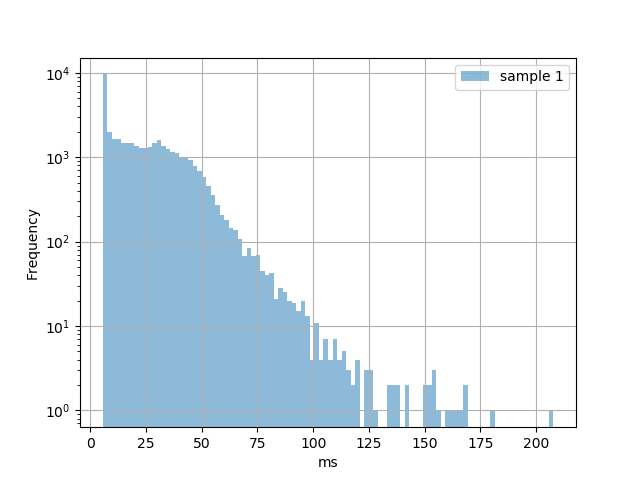

<IPython.core.display.Javascript object>


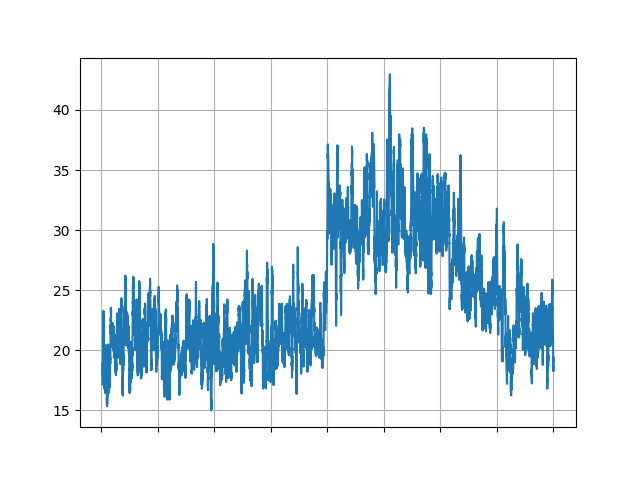

In [10]:
df_dataw = df[(df["buf type"] == "data") & (df["RW"] == "W")]["time_ms"]

plt.figure()
ax = df_dataw.plot(kind="hist", bins=100, logy=True, alpha=0.5, legend=True, label="sample 1", grid=True)
ax.set_xlabel("ms")
plt.show()

plt.figure() 
df_dataw.rolling(100).mean().plot(grid=True)
plt.show()

Now for example, if we want to see the time elapsed between these operations:

<IPython.core.display.Javascript object>


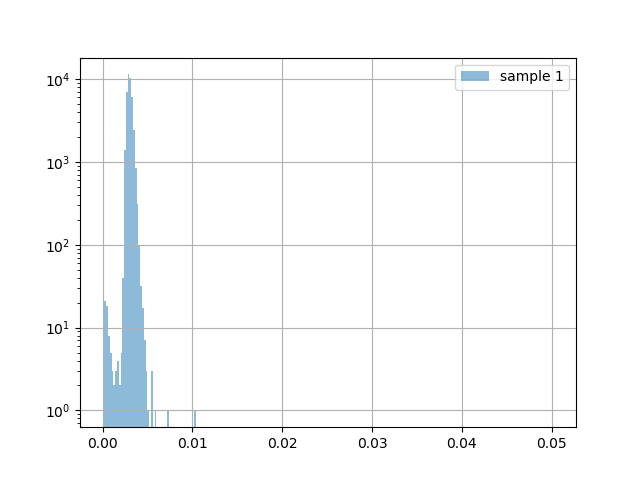

<IPython.core.display.Javascript object>


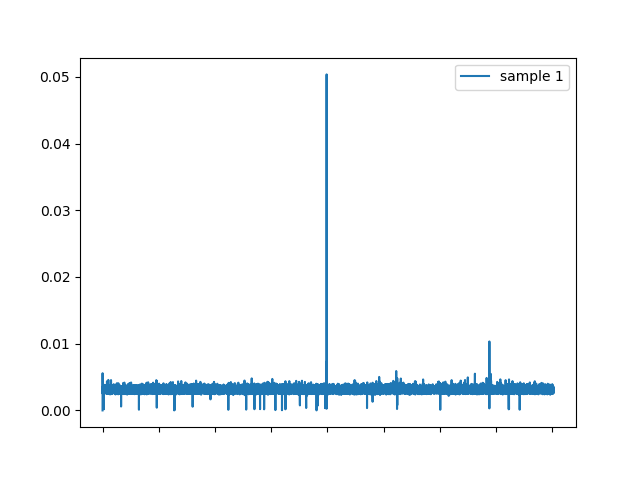

In [13]:
import numpy as np
df_dataw = df[(df.RW == "W") & (df["buf type"] == "data")]

df["T"] = pd.to_datetime(df.index.sort_values())
diff = pd.to_numeric((df["T"] - df["T"].shift())) / 1e9
diff[diff < 0] = 0

plt.figure()
bins = np.arange(0, diff.max(), 0.0002)
diff.hist(bins=bins, alpha=0.5, label="sample 1")
plt.legend(loc="best")
plt.semilogy()
plt.show()
#df_w["T"]

plt.figure()
diff.plot(label="sample 1")
plt.legend(loc="best")
plt.show()

